In [113]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage.draw import polygon
import numpy as np
import pandas as pd
import os
import plistlib
import random
from subprocess import Popen
import math
PATH = "/mnt/d/Datasets/INbreast/"
ROI_PATH = PATH + "AllXML/"
IMG_PATH = PATH + "All-IMGS/"
save = PATH + 'full/'
img_width = 300
img_height = 600
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(1,1))

In [114]:
# for dirName, subdirList, fileList in os.walk(IMG_PATH):
    # for fname in fileList:
        # if fname.endswith('.dcm'):
            # dcm_path = dirName+'/'+fname
            # img_path = dirName+'/'+fname.replace('.dcm','.png')
            # Popen(['convert',dcm_path,img_path]).wait()

In [115]:
inbreast = pd.read_csv(PATH + "INbreast.csv", encoding="ISO-8859-1" )
file_id = inbreast['File Name'].to_numpy()
birads = inbreast['Bi-Rads'].to_numpy()

In [116]:
file_name = '20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm'
id = file_name.split('_')[0]
row = inbreast.loc[inbreast['File Name']==id]
print(row['Bi-Rads'].to_numpy())

[]


In [117]:
benign = inbreast.loc[inbreast['Bi-Rads']=='2']
malignant = inbreast.loc[inbreast['Bi-Rads']!='2']
malignant = malignant.loc[malignant['Bi-Rads']!='1']
malignant = malignant[:-2]
rng = np.random.default_rng(seed=42)
malignant= rng.permutation(malignant['File Name'].to_numpy())
benign= rng.permutation(benign['File Name'].to_numpy())
# benign = benign[:len(malignant)]
test_set = int(0.2*len(benign))
val_set = int(0.8*0.2*len(benign))
train_set = len(benign) - test_set - val_set
benign_train = benign[:train_set]
benign_val = benign[train_set:-test_set]
benign_test = benign[-test_set:]
test_set = int(0.2*len(malignant))
val_set = int(0.8*0.2*len(malignant))
train_set = len(malignant) - test_set - val_set
malignant_train = malignant[:train_set]
malignant_val = malignant[train_set:-test_set]
malignant_test = malignant[-test_set:]
# print(train_set)


In [118]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.5),fill_mode='constant'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2),fill_mode='constant'),
  tf.keras.layers.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1),fill_mode='constant')
  ])

In [119]:
def preprocess(file_path):
    data = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
    # data_blur = cv2.GaussianBlur(data, (5, 5), 5)
    # _, thresh = cv2.threshold(data_blur, 250, 255, cv2.THRESH_BINARY_INV)
    # contours, _ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # largest_contours = max(contours, key=cv2.contourArea)
    # img_contour = np.zeros(data.shape,np.uint8)
    # cv2.drawContours(img_contour, [largest_contours], -1, 255, -1)
    # img_no_bg = cv2.bitwise_and(data_blur,data_blur,mask=img_contour)
    # _, thresh = cv2.threshold(img_no_bg, 10, 255, cv2.THRESH_BINARY)
    # contours, _ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # largest_contours = max(contours, key=cv2.contourArea)
    # img_contour = np.zeros(data.shape,np.uint8)
    # cv2.drawContours(img_contour, [largest_contours], -1, 255, -1)
    # img_no_label = cv2.bitwise_and(img_no_bg,img_no_bg,mask=img_contour) 
    # data = clahe.apply(data)
    img=cv2.resize(data,(img_width,img_height))
    return img

def process_image(file_path,data_set,category,file_save,augment=False):
    # image_dir = tf.compat.as_str(file_path.numpy())
    image_dir = file_path
    image = preprocess(image_dir)
    image_name = image_dir.split('/')[-1].split('.')[0]
    save_path = str(save) + str(data_set) +'/'+str(category)+'/'+str(file_save)
    print(save_path) 
    directory = str(save) + str(data_set) +'/'+str(category)
    if not os.path.exists(directory):
        os.makedirs(directory)
    cv2.imwrite(save_path+'_1.png',image)
    img = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    if augment:
        for i in range(augment):
            img2 = data_augmentation(img)    
            cv2.imwrite(save_path+'_'+str(i+2)+'.png',img2.numpy())

In [120]:
for dirName, subdirList, fileList in os.walk(IMG_PATH):
    for file in fileList:
        if file.endswith('.png'):
            file_name = float(file.split('_')[0])
            if file_name in benign:
                if file_name in benign_val:
                    process_image(dirName+'/'+file,'val','benign',int(file_name))
                elif file_name in benign_test:
                    process_image(dirName+'/'+file,'test','benign',int(file_name))
                else:
                    process_image(dirName+'/'+file,'train','benign',int(file_name),augment=4)
            elif file_name in malignant:
                if file_name in malignant_val:
                    process_image(dirName+'/'+file,'val','malignant',int(file_name))
                elif file_name in malignant_test:
                    process_image(dirName+'/'+file,'test','malignant',int(file_name))
                else:
                    process_image(dirName+'/'+file,'train','malignant',int(file_name),augment=8)
            else:
                print(str(file_name)+' not selected')

/mnt/d/Datasets/INbreast/full/val/benign/20586908
/mnt/d/Datasets/INbreast/full/val/malignant/20586934
/mnt/d/Datasets/INbreast/full/test/benign/20586960
/mnt/d/Datasets/INbreast/full/train/malignant/20586986
/mnt/d/Datasets/INbreast/full/train/malignant/20587054
/mnt/d/Datasets/INbreast/full/test/malignant/20587080
/mnt/d/Datasets/INbreast/full/train/benign/20587148
/mnt/d/Datasets/INbreast/full/train/benign/20587174
/mnt/d/Datasets/INbreast/full/train/benign/20587200
/mnt/d/Datasets/INbreast/full/train/benign/20587226
/mnt/d/Datasets/INbreast/full/val/benign/20587294
/mnt/d/Datasets/INbreast/full/train/benign/20587320
/mnt/d/Datasets/INbreast/full/train/benign/20587346
/mnt/d/Datasets/INbreast/full/train/benign/20587372
/mnt/d/Datasets/INbreast/full/test/benign/20587466
/mnt/d/Datasets/INbreast/full/train/benign/20587492
/mnt/d/Datasets/INbreast/full/train/benign/20587518
/mnt/d/Datasets/INbreast/full/test/benign/20587544
/mnt/d/Datasets/INbreast/full/train/malignant/20587612
/mnt/d/

In [35]:
benign = []
asymmetry = inbreast.loc[inbreast['Asymmetry']=='X']
asymmetry_benign = asymmetry.loc[asymmetry['Bi-Rads']=='2']
print(asymmetry_benign)
asymmetry_malignant = asymmetry.loc[asymmetry['Bi-Rads']!='2']
print(asymmetry_malignant)


[['removed' 'removed' 'R' 'CC' 200902.0 24058660.0 '1' '2' nan 'X' nan
  'X' 'densidade assimétrica mama esquerda + micros' nan nan nan nan nan
  nan nan nan nan]
 ['removed' 'removed' 'R' 'MLO' 200902.0 24058712.0 '1' '2' nan 'X' nan
  'X' 'densidade assimétrica mama esquerda + micros' nan nan nan nan nan
  nan nan nan nan]
 ['removed' 'removed' 'L' 'MLO' 200901.0 24065380.0 '2' '2' nan nan nan
  'X' 'densidade assimetrica TQS ' nan nan nan nan nan nan nan nan nan]
 ['removed' 'removed' 'L' 'CC' 200901.0 24065434.0 '2' '2' nan nan nan
  'X' 'densidade assimetrica TQS' nan nan nan nan nan nan nan nan nan]
 ['removed' 'removed' 'R' 'CC' 200902.0 22580492.0 '3' '2' nan 'X' nan
  'X' 'densidade assimetrica QSE à esquerda' nan nan nan nan nan nan nan
  nan nan]
 ['removed' 'removed' 'R' 'MLO' 200902.0 22580548.0 '3' '2' nan 'X' nan
  'X' 'densidade assimetrica QSE à esquerda' nan nan nan nan nan nan nan
  nan nan]]
[['removed' 'removed' 'L' 'CC' 201001.0 22670465.0 '2' '5' 'X' 'X' nan
  'X

In [37]:
micros = inbreast.loc[inbreast['Micros']=='X']
micros_benign = micros.loc[micros['Bi-Rads']=='2'].to_numpy()
print(micros_benign)
micros_malignant = micros.loc[micros['Bi-Rads']!='2'].to_numpy()
print(micros_malignant)


[['removed' 'removed' 'L' ... nan nan nan]
 ['removed' 'removed' 'L' ... nan nan nan]
 ['removed' 'removed' 'L' ... nan nan nan]
 ...
 ['removed' 'removed' 'R' ... nan nan nan]
 ['removed' 'removed' 'L' ... nan nan nan]
 ['removed' 'removed' 'R' ... nan nan nan]]
[['removed' 'removed' 'R' ... nan nan nan]
 ['removed' 'removed' 'R' ... nan nan nan]
 ['removed' 'removed' 'R' ... nan nan nan]
 ...
 ['removed' 'removed' 'L' ... nan nan nan]
 ['removed' 'removed' 'R' ... nan nan nan]
 ['removed' 'removed' 'R' ... nan nan nan]]


In [3]:
def load_mask(mask_path, imshape=(4084, 3328)):
    """
    This function loads a osirix xml region as a binary numpy array for INBREAST
    dataset
    @mask_path : Path to the xml file
    @imshape : The shape of the image as an array e.g. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    """

    mask = np.zeros(imshape)
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        for roi in rois:
            numPoints = roi['NumberOfPoints']
            points = roi['Point_px']
            assert numPoints == len(points)
            points = [eval(point) for point in points]
            if len(points) <= 2:
                for point in points:
                    mask[int(point[1]), int(point[0])] = 1
            else:
                x, y = zip(*points)
                col, row = np.array(x), np.array(y) ##x coord is the column coord in an image and y is the row
                poly_x, poly_y = polygon(row, col, shape=imshape)
                mask[poly_x, poly_y] = 1
    return mask

#Reference from https://gist.github.com/Feyn-Man/de6f62997d051fc6ff75a6aa968537f5, Accessed on 12/1/2023


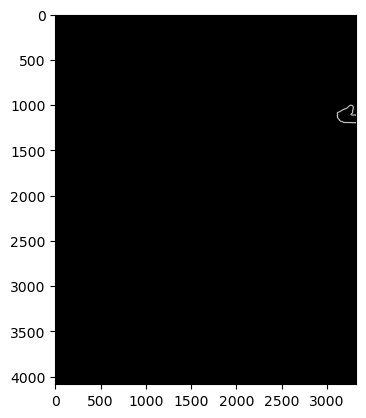

In [4]:

# To load largest ROI in XML file
mask = np.zeros((4084,3328))
with open(ROI_PATH + "20586908.xml", 'rb') as mask_file:
    plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
    numRois = plist_dict['NumberOfROIs']
    rois = plist_dict['ROIs']
    assert len(rois) == numRois
    prevPoints = 0
    for roi in rois:
        numPoints = roi['NumberOfPoints']
        points = roi['Point_px']
        assert numPoints == len(points)
        points = [eval(point) for point in points]
        if numPoints > prevPoints:
            point = points
            prevPoints = numPoints
    for x in point:
        mask[int(x[1])-5:int(x[1])+5, int(x[0])-5:int(x[0])+5] = 1

plt.imshow(mask, cmap='gray')

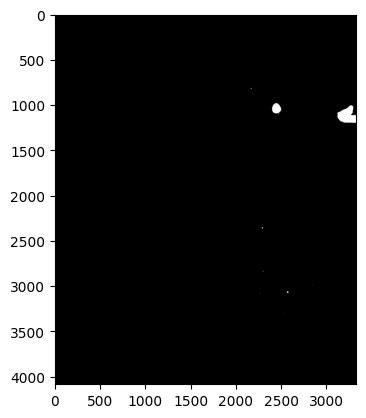

In [86]:
Test_box = load_mask(ROI_PATH + "20586908.xml")
# ret,thresh = cv2.threshold(Test_box,127,255,0)
# contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# x,y,w,h = cv2.boundingRect(contours[0])
# img = cv2.rectangle(Test_box,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(Test_box, cmap='gray')